In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, lightgbm, math, itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GroupKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

np.set_printoptions(linewidth=150, edgeitems=5)
result_list = []

In [7]:
train = pd.read_csv('train.csv', index_col='ID')
test = pd.read_csv('test.csv', index_col='ID')
# original = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')
# original.rename(columns={"CementComponent ": "CementComponent"}, inplace=True)

target = 'y'
original_features = list(test.columns)

print(f"Length of train: {len(train)}")
print(f"Length of test:  {len(test)}")
# print(f"Length of original: {len(original)}")
print()

temp1 = train.isna().sum().sum()
temp2 = test.isna().sum().sum()
if temp1 == 0 and temp2 == 0:
    print('There are no null values in train and test.')
else:
    print(f'There are {temp1} null values in train')
    print(f'There are {temp2} null values in train')
print()

print('Sample lines from train:')
train.tail(3)

Length of train: 40118
Length of test:  4986

There are no null values in train and test.

Sample lines from train:


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
ID,,,,,,,,,,,,
TRAIN_40115,1.084876,-2.143004,1.244276,0.891797,-0.248833,-1.807747,0.478165,-0.168244,0.650180,0.293320,0.089925,84.745801
TRAIN_40116,0.994186,-1.562092,1.227734,0.908147,-0.313856,-1.718209,0.477257,-0.109262,0.589458,0.353898,0.042610,86.192975
TRAIN_40117,1.090381,-2.379771,1.172301,0.847332,-0.269832,-1.777072,0.501342,-0.204711,0.694926,0.249208,0.088814,83.699707


In [8]:
def score_model(model, features_used, label=None):
    """Cross-validate a model with selected features"""
    score_list = []
    oof = np.zeros_like(train[target])
    kf = KFold(shuffle=True, random_state=333)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train,
                                                     groups=train[original_features].apply(tuple, axis=1))):
        X_tr = train.iloc[idx_tr][features_used]
        X_va = train.iloc[idx_va][features_used]
        y_tr = train.iloc[idx_tr][target]
        y_va = train.iloc[idx_va][target]
        
#         X_tr = pd.concat([X_tr, original[features_used]], axis=0)
#         y_tr = pd.concat([y_tr, original[target]], axis=0)
        
        model.fit(X_tr, y_tr)
        trmse = mean_squared_error(y_tr, model.predict(X_tr), squared=False)
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        if type(model) == Pipeline and type(model.steps[-1][1]) == Ridge:
            print('Weights:', model.steps[-1][1].coef_.round(2))
        print(f"Fold {fold}: trmse = {trmse:.3f}   rmse = {rmse:.3f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    print(f"Average rmse: {rmse:.3f} {label if label is not None else ''}")
    if label is not None:
        global result_list
        result_list.append((label, rmse, oof))
    idxs = np.argsort(oof)
    oof_i = oof[idxs]
    y_true_i = train[target].iloc[idxs]
    s = pd.Series(y_true_i.values, index=oof_i)
    s = s.rolling(100, center=True).mean()
    plt.figure(figsize=(10, 4))
    ax = plt.subplot(1, 2, 1) # y_true vs. y_pred
    plt.scatter(oof, train[target], s=3)
    ax.scatter(s.index, s, s=2, c='r')
    ax.plot([s.index.min(), s.index.max()], [s.index.min(), s.index.max()], c='y', lw='2')
    ax.set_aspect('equal')
    ax.set_xlabel('y_pred')
    ax.set_ylabel('y_true')
    plt.subplot(1, 2, 2) # histogram
    plt.hist(oof, bins=100)
    plt.xlabel('y_pred')
    plt.ylabel('count')
    plt.show()

Weights: [-0.71  0.54  0.11 -0.25  0.8   0.3   0.55 -0.16  0.85 -0.39]
Fold 0: trmse = 1.649   rmse = 1.759
Weights: [-0.74  0.54  0.13 -0.2   0.85  0.35  0.57 -0.26  0.77 -0.37]
Fold 1: trmse = 1.683   rmse = 1.626
Weights: [-0.68  0.54  0.14 -0.28  0.76  0.32  0.61 -0.25  0.69 -0.36]
Fold 2: trmse = 1.688   rmse = 1.605
Weights: [-0.7   0.57  0.14 -0.19  0.83  0.32  0.54 -0.15  0.81 -0.45]
Fold 3: trmse = 1.690   rmse = 1.596
Weights: [-0.7   0.53  0.13 -0.2   0.77  0.33  0.54 -0.22  0.79 -0.43]
Fold 4: trmse = 1.647   rmse = 1.765
Average rmse: 1.670 Ridge


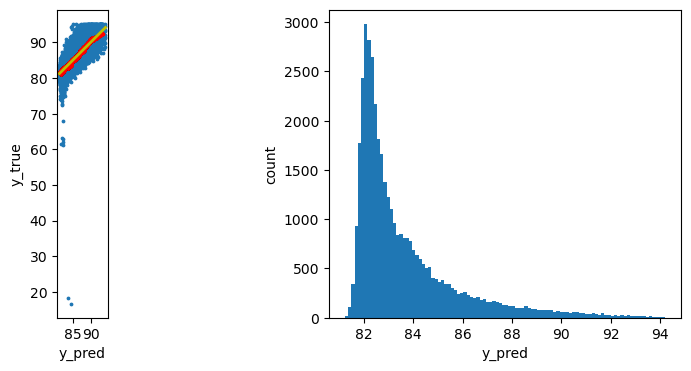

In [9]:
ridge_features = ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10'
                    ]
score_model(model=make_pipeline(StandardScaler(), Ridge(30)),
            features_used=ridge_features,
            label='Ridge')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 32094, number of used features: 11
[LightGBM] [Info] Start training from score 83.635322
Fold 0: trmse = 1.625   rmse = 1.759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 32094, number of used features: 11
[LightGBM] [Info] Start training from score 83.637405
Fold 1: trmse = 1.660   rmse = 1.625
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

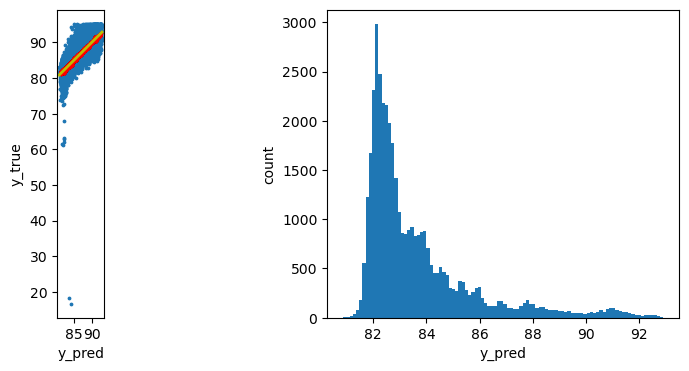

In [11]:
lgbm_params = {
        'learning_rate': 0.0005,
        'n_estimators': 20000,
        'num_leaves': 7,
        'colsample_bytree': 0.4,
        'subsample': 0.5,
        'subsample_freq': 6,
        'min_child_samples': 25,
    }

score_model(model=lightgbm.LGBMRegressor(**lgbm_params, random_state=1),
            features_used=original_features,
            label='LGBM')

Fold 0: trmse = 1.617   rmse = 1.760
Fold 1: trmse = 1.652   rmse = 1.623
Fold 2: trmse = 1.656   rmse = 1.606
Fold 3: trmse = 1.658   rmse = 1.593
Fold 4: trmse = 1.618   rmse = 1.761
Average rmse: 1.669 GradientBoostingRegressor


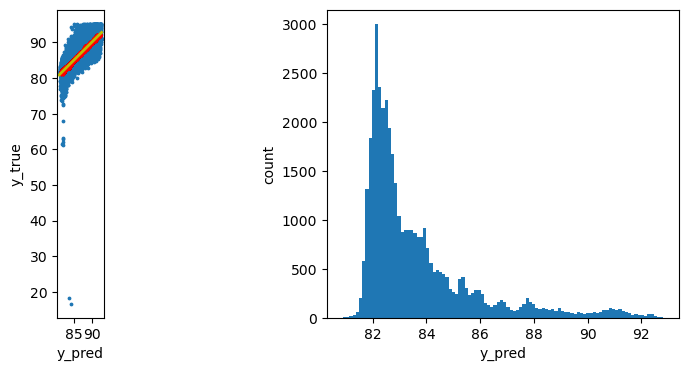

In [12]:
gbr_params = {'n_estimators': 600,
              'max_depth': 4,
              'learning_rate': 0.01,
              'min_samples_leaf': 40 ,
              'max_features': 3}
score_model(model=make_pipeline(GradientBoostingRegressor(**gbr_params, random_state=2)),
            features_used=original_features,
            label='GradientBoostingRegressor')

Fold 0: trmse = 1.590   rmse = 1.757
Fold 1: trmse = 1.626   rmse = 1.621
Fold 2: trmse = 1.630   rmse = 1.602
Fold 3: trmse = 1.632   rmse = 1.591
Fold 4: trmse = 1.590   rmse = 1.759
Average rmse: 1.666 GradientBoostingRegressor + RF + Ridge


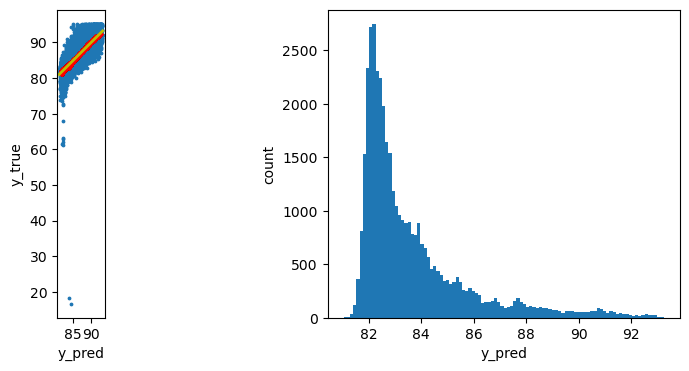

In [16]:
ensemble_model = VotingRegressor([('gb', make_pipeline(
                                                       ColumnTransformer([('pt', 'passthrough', original_features)]),
                                                       GradientBoostingRegressor(**gbr_params, random_state=1))),
                                  ('rf', make_pipeline(
                                                       ColumnTransformer([('pt', 'passthrough', original_features)]),
                                                       RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1))),
                                  ('ridge', make_pipeline(
                                                          ColumnTransformer([('pt', 'passthrough', ridge_features)]),
                                                          StandardScaler(),
                                                          Ridge(30))),
                                 ],
                                 weights=[0.35, 0.3, 0.35])
score_model(model=ensemble_model,
            features_used=test.columns,
            label='GradientBoostingRegressor + RF + Ridge')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 32094, number of used features: 11
[LightGBM] [Info] Start training from score 83.635322
Fold 0: trmse = 1.590   rmse = 1.757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 32094, number of used features: 11
[LightGBM] [Info] Start training from score 83.637405
Fold 1: trmse = 1.626   rmse = 1.621
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in t

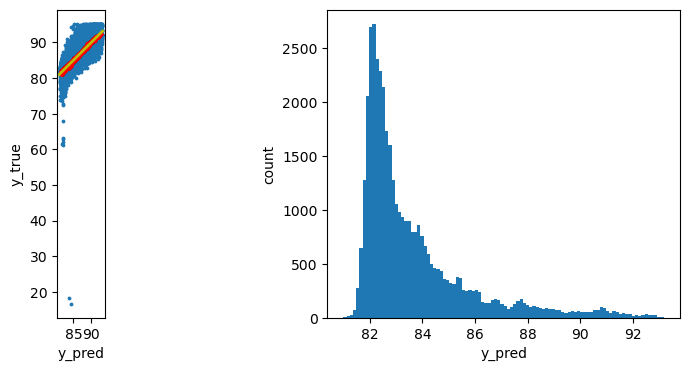

In [17]:
ensemble_model = VotingRegressor([('gb', make_pipeline(
                                                       ColumnTransformer([('pt', 'passthrough', original_features)]),
                                                       GradientBoostingRegressor(**gbr_params, random_state=1))),
                                  ('lgbm', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                                                         lightgbm.LGBMRegressor(**lgbm_params, random_state=1))),
                                  ('rf', make_pipeline(
                                                       ColumnTransformer([('pt', 'passthrough', original_features)]),
                                                       RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1))),
                                  ('ridge', make_pipeline(
                                                          ColumnTransformer([('pt', 'passthrough', ridge_features)]),
                                                          StandardScaler(),
                                                          Ridge(30))),
                                 ],
                                 weights=[0.2, 0.2, 0.3, 0.3])
score_model(model=ensemble_model,
            features_used=test.columns,
            label='GradientBoostingRegressor + LGBM + RF + Ridge')

In [ ]:
result_df = pd.DataFrame(result_list, columns=['label', 'rmse', 'oof'])
result_df.drop_duplicates(subset='label', keep='last', inplace=True)

In [ ]:
result_df.sort_values('rmse', inplace=True)
with pd.option_context("precision", 3):
    display(result_df[['label', 'rmse']])
plt.figure(figsize=(6, len(result_df) * 0.3))
plt.title('Final comparison')
plt.barh(np.arange(len(result_df)), result_df.rmse, color='orange')
plt.gca().invert_yaxis()
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.xticks(np.linspace(12.0, 12.2, 5))
plt.xlabel('RMSE')
plt.xlim(12.0, 12.2)
plt.show()

In [18]:
ensemble_model.fit(train[test.columns], train[target])
y_pred = ensemble_model.predict(test[test.columns])
pd.Series(y_pred, index=test.index, name=target).to_csv(f"s3.csv")
y_pred.round(1)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 40118, number of used features: 11
[LightGBM] [Info] Start training from score 83.638201


array([83.6, 82.2, 90.6, 91.3, 82.2, ..., 83.4, 91.5, 82.7, 83. , 82.2])